## Feature Importance

Making sure we are in the data1030 environment before proceeding.

In [2]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.10 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.10"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.10"):
    print(FAIL, "Python version 3.10 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "1.22.4", 'matplotlib': "3.5.2",'sklearn': "1.1.1", 
                'pandas': "1.4.2",'xgboost': "1.5.1", 'shap': "0.40.0"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.10.5

[ OK ] numpy version 1.22.4 is installed.
[ OK ] matplotlib version 3.5.2 is installed.
[ OK ] sklearn version 1.1.1 is installed.
[ OK ] pandas version 1.4.2 is installed.
[ OK ] xgboost version 1.5.1 is installed.
[ OK ] shap version 0.40.0 is installed.


In [33]:
#important packages
import pandas as pd
import numpy as np
import scipy.stats as st #used in viz
import random

#visualization packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#model selection packages
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, ParameterGrid

#preprocessing packages
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#import metrics
from sklearn.metrics import mean_squared_error, accuracy_score
import math

#model packages
from sklearn.ensemble import RandomForestRegressor

from sklearn.inspection import permutation_importance
import shap

import warnings
warnings.filterwarnings('ignore')

### Preparing the data

In [34]:
#loading in the dataframe from EDA
%store -r df

In [35]:
#identifying our target variable y
y = df['distress_score']
#all other columns are features 
X = df.loc[:, df.columns != 'distress_score'] 
#feature names
ftrs = df.columns
print(ftrs)

Index(['state', 'census_region', 'community_class', 'total_population',
       '%_adults_wo_hs', 'poverty_rate', '%_adults_not_employed',
       'vacancy_rate', 'median_income_ratio', '%_change_in_employment',
       '%_change_in_establishments', 'distress_score',
       '%_pop_non_hispanic_white', '%_pop_hispanic_or_latino',
       '%_pop_black_or_african_american',
       '%_pop_american_indian_or_alaska_native',
       '%_pop_asian_or_pacific_islander', '%_pop_other_race',
       '%_pop_foreign_born', '%_pop_bachelors_degree_or_higher'],
      dtype='object')


In [36]:
#let's split to train, CV, and test
X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state=126)
X_train, X_CV, y_train, y_CV = train_test_split(X_other, y_other, test_size=0.25, random_state=126)

print(X_train.shape)
print(X_CV.shape)
print(X_test.shape)

(15459, 19)
(5153, 19)
(5154, 19)


In [37]:
#list of our features by what transformer they need
cat_ftrs = ['state', 'census_region', 'community_class']

num_ftrs = ['total_population', '%_adults_wo_hs', 'poverty_rate', \
            '%_adults_not_employed', 'vacancy_rate', 'median_income_ratio', \
            '%_change_in_employment', '%_change_in_establishments', \
            '%_pop_non_hispanic_white', '%_pop_hispanic_or_latino', \
            '%_pop_black_or_african_american', '%_pop_american_indian_or_alaska_native', \
            '%_pop_asian_or_pacific_islander', '%_pop_other_race', '%_pop_foreign_born', \
            '%_pop_bachelors_degree_or_higher'
            ]

In [38]:
#collecting all the encoders
#onehot encoder
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

#standard scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])


# collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs)])

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), onehot_ftrs),
#         ('std', StandardScaler(), std_ftrs)])

# #for now we only preprocess, later we will add other steps here
# prep = Pipeline(steps=[('preprocessor', preprocessor)])

### RandomForestRegressor Built-In Feature Importance

In [24]:
#loading in the best performing model
%store -r rf_best_models

In [25]:
print(rf_best_models)

RandomForestRegressor(max_depth=30, max_features=0.5, random_state=126)


In [39]:
# fit_transform the training set
X_train_prep = preprocessor.fit_transform(X_train)

# transform the CV
X_CV_prep = preprocessor.transform(X_CV)

# transform the test
X_test_prep = preprocessor.transform(X_test)

In [40]:
feature_names = preprocessor.get_feature_names_out()

df_train = pd.DataFrame(data=X_train_prep,columns=feature_names)
print(df_train.shape)

df_CV = pd.DataFrame(data=X_CV_prep,columns = feature_names)
print(df_CV.shape)

df_test = pd.DataFrame(data=X_test_prep,columns = feature_names)
print(df_test.shape)

(15459, 75)
(5153, 75)
(5154, 75)


In [41]:
#train the best model
import pickle

#best params we found for randomforestregressor
param_grid = {
    'max_depth': [30],
    'max_features': [0.5]}

#RandomForestRegressor
model = RandomForestRegressor(random_state=42)

model.set_params(**ParameterGrid(param_grid)[0])
model.fit(df_train,y_train)
best_model = model

y_CV_pred = model.predict(df_CV)
print('the CV RMSE:',np.sqrt(mean_squared_error(y_CV,y_CV_pred)))

y_test_pred = model.predict(df_test)
print('the test RMSE:',np.sqrt(mean_squared_error(y_test,y_test_pred)))

the CV RMSE: 3.0802040291902646
the test RMSE: 3.122919464346082


In [13]:
#random forest built-in feature importance
default_importance = model.feature_importances_

#turning into a series
default_importance = pd.Series(default_importance, index=feature_names)

#absolute value, sorting, and retaining only top 10 features
abs_default_importances = np.abs(default_importance).sort_values(ascending=False)[:10]

#collecting the top 10 feature names in a list
default_feature_list = abs_default_importances.index.to_list()
default_values_list = list(abs_default_importances.values)
default_dict = dict(zip(default_feature_list, default_values_list))

#zipping together to create a nested dictionary for this metric
#of the top 10 features and their respective values from the metric
default_dict1 = dict(zip(default_feature_list, default_values_list))
default_dict = {}
default_dict['totcover'] = dict(default_dict1.items())

#checking out the dictionary
default_dict

{'totcover': {'num__poverty_rate': 0.3513798298840855,
  'num__median_income_ratio': 0.18870756622272764,
  'num__%_adults_wo_hs': 0.11496605739354375,
  'num__%_adults_not_employed': 0.093238593150681,
  'num__vacancy_rate': 0.0850889779069239,
  'num__%_change_in_establishments': 0.06628046460541356,
  'num__%_change_in_employment': 0.0632732942914501,
  'num__%_pop_bachelors_degree_or_higher': 0.021461395496261353,
  'num__total_population': 0.0019537679668271677,
  'num__%_pop_non_hispanic_white': 0.0018627036838028326}}

In [370]:
# #saving global ftrs to results
# filename = '../results/builtin_feature_importance.save'
# pickle.dump(default_dict, open(filename, 'wb'))

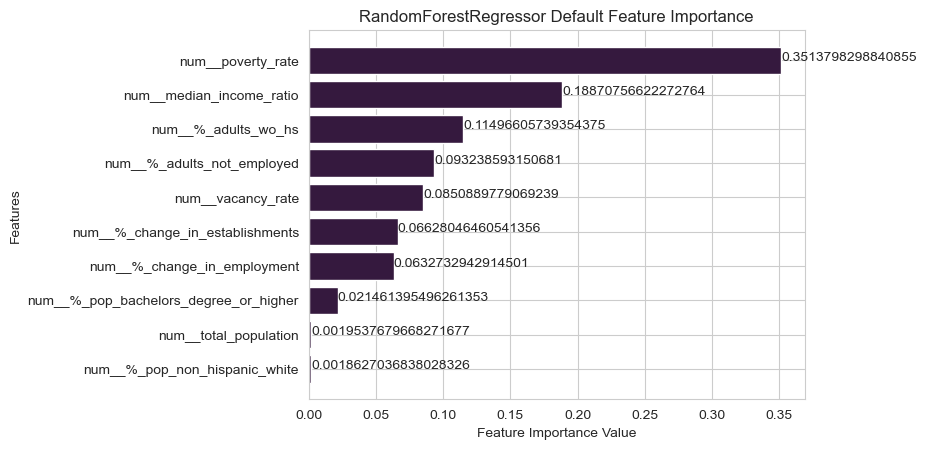

In [383]:
##visualize results - top 10 most important features
default_rev_ftrs = list(reversed(default_feature_list))
default_rev_vals = abs_default_importances.sort_values(ascending=True)

plt.barh(range(10), default_rev_vals)
plt.yticks(range(10), default_rev_ftrs)
plt.xlabel("Feature Importance Value")
plt.ylabel("Features")
plt.title("RandomForestRegressor Default Feature Importance")
for index, value in enumerate(default_rev_vals):
    plt.text(value, index, str(value))
# plt.savefig('../figures/RF_feature_importance.png', bbox_inches='tight')
plt.show()

### SHAP Value Feature Importance

In [32]:
##calculate the shap values of the test set points
import shap
#for visualization
shap.initjs()

In [50]:
#create the explainer object with the random forest model
explainer_rf_class = shap.TreeExplainer(model)

In [17]:
##use the shap values to calculate global feature importance values 
shap_values = explainer_rf_class.shap_values(df_test)

In [18]:
%store shap_values

Stored 'shap_values' (ndarray)


In [29]:
%store -r shap_values

In [42]:
vals = np.abs(shap_values).mean(0)

In [43]:
shap_importance = pd.Series(vals, index=feature_names)
abs_shap_importances = np.abs(shap_importance).sort_values(ascending=False)[:10]

#collecting the top 10 feature names in a list
shap_feature_list = abs_shap_importances.index.to_list()
shap_values_list = list(abs_shap_importances.values)

#zipping together to create a nested dictionary for this metric
#of the top 10 features and their respective values from the metric
shap_dict1 = dict(zip(shap_feature_list, shap_values_list))
shap_dict = {}
shap_dict['shap_val'] = dict(shap_dict1.items())

In [21]:
#checking out the dictionary
shap_dict

{'shap_val': {'num__poverty_rate': 9.69419392081887,
  'num__median_income_ratio': 6.853933657241758,
  'num__vacancy_rate': 5.60186496582691,
  'num__%_adults_wo_hs': 5.457289193587231,
  'num__%_change_in_employment': 5.346738150557454,
  'num__%_change_in_establishments': 5.290709091627563,
  'num__%_adults_not_employed': 5.108016739667089,
  'num__%_pop_bachelors_degree_or_higher': 0.8761885511558279,
  'num__%_pop_non_hispanic_white': 0.09861171063692256,
  'cat__census_region_South': 0.0690297136515207}}

In [371]:
# #saving global ftrs to results
# filename = '../results/shap_feature_importance.save'
# pickle.dump(shap_dict, open(filename, 'wb'))

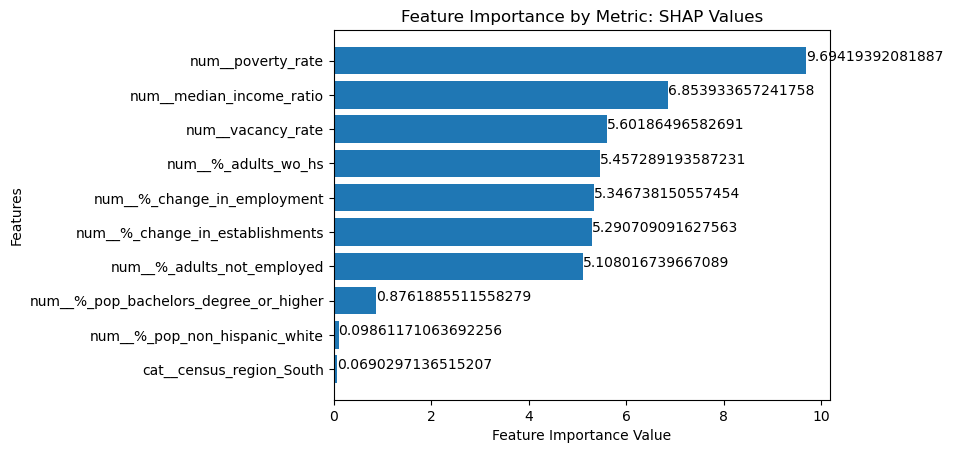

In [46]:
##visualize results - top 10 most important features
shap_rev_ftrs = list(reversed(shap_feature_list))
shap_rev_vals = abs_shap_importances.sort_values(ascending=True)

plt.barh(range(10), shap_rev_vals)
plt.yticks(range(10), shap_rev_ftrs)
plt.xlabel("Feature Importance Value")
plt.ylabel("Features")
plt.title("Feature Importance by Metric: SHAP Values")
for index, value in enumerate(shap_rev_vals):
    plt.text(value, index, str(value))
plt.show();

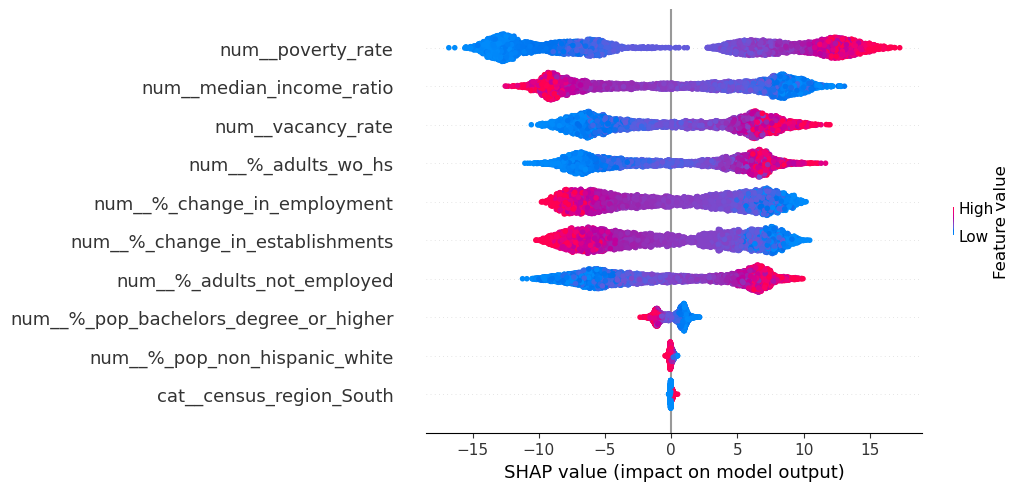

In [47]:
#shap values to calculate global feature importance values 
#creating a dataframe of the feature names and the mean of shap values
feature_importance = pd.DataFrame(
    list(zip(df_test.columns, vals)),
    columns=["col_name", "feature_importance_vals"],
)

#sorting by the values
feature_importance.sort_values(
    by=["feature_importance_vals"], ascending=False, inplace=True
)

#want only the top 10 features
feature_importance['rank'] = feature_importance['feature_importance_vals'].rank(method='max',ascending=False)
rename_col = {}
column_names = feature_importance["col_name"][:10].values.tolist()
feature_index = feature_importance.index[:10].tolist()


##prepare a plot that shows the top 10 most important features
shap.summary_plot(
    shap_values[:, feature_index].reshape(
        df_test.shape[0], len(feature_index)),
    df_test.rename(columns=rename_col)[column_names],
    max_display=len(feature_index), 
    show=False
        )
# plt.savefig('../figures/shap_feature_importance.png', bbox_inches='tight')
plt.show()

In [44]:
len(shap_values)

5154

Checking a few local importances

In [52]:
#messing around w local feature importance
#index of the point to explain
index = 0
print(explainer_rf_class.expected_value)
shap.force_plot(explainer_rf_class.expected_value, shap_values[index,:], \
                df_test.iloc[index,:], feature_names = feature_names)

[49.77940022]


In [53]:
#messing around w local feature importance
#index of the point to explain
index = 5000
print(explainer_rf_class.expected_value)
shap.force_plot(explainer_rf_class.expected_value, shap_values[index,:], \
                df_test.iloc[index,:], feature_names = feature_names)

[49.77940022]


### Permutation

In [25]:
from sklearn.inspection import permutation_importance
random_state = 42

##calculate the perturbation feature importance values on the test set
perm = permutation_importance(model, df_test, y_test, random_state=random_state, scoring='r2')

#turning into a series and taking the mean
forest_importances = pd.Series(perm.importances_mean, index=feature_names)

#absolute value, sorting, and retaining only top 10 features
abs_forest_importances = np.abs(forest_importances).sort_values(ascending=False)[:10]

In [26]:
#collecting the top 10 feature names in a list
perm_feature_list = abs_forest_importances.index.to_list()
perm_values_list = list(abs_forest_importances.values)

perm_dict1 = dict(zip(perm_feature_list, perm_values_list))
perm_dict = {}
perm_dict['perm'] = dict(perm_dict1.items())

In [27]:
#checking out the dictionary
perm_dict

{'perm': {'num__poverty_rate': 0.11763191449480606,
  'num__median_income_ratio': 0.08850269633483247,
  'num__%_change_in_employment': 0.08518539077927176,
  'num__%_change_in_establishments': 0.08171775490171593,
  'num__vacancy_rate': 0.07976979138723883,
  'num__%_adults_not_employed': 0.07127452225498306,
  'num__%_adults_wo_hs': 0.07107323591242085,
  'num__%_pop_bachelors_degree_or_higher': 0.0016304017406378658,
  'num__total_population': 0.0002465878774172259,
  'num__%_pop_non_hispanic_white': 0.00018095021716244553}}

In [372]:
# #saving global ftrs to results
# filename = '../results/permutation_feature_importance.save'
# pickle.dump(perm_dict, open(filename, 'wb'))

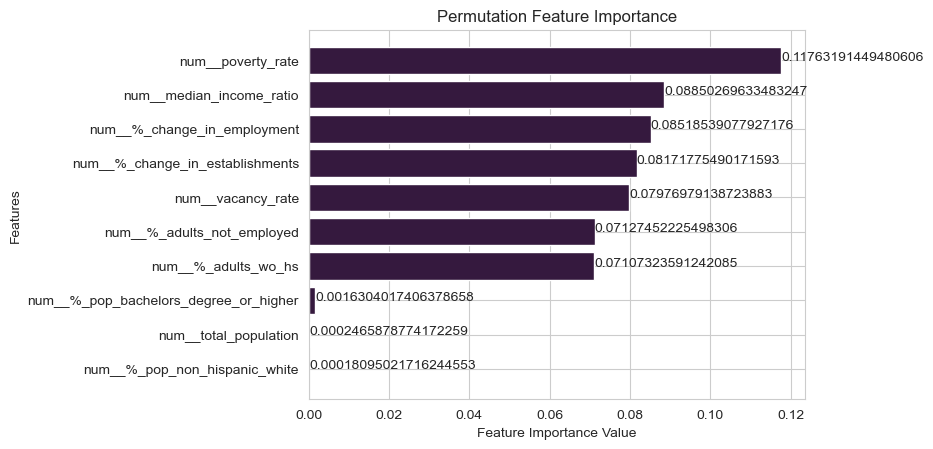

In [379]:
##visualize results - top 10 most important features
import matplotlib.pyplot as plt
perm_rev_ftrs = list(reversed(perm_feature_list))
perm_rev_vals = abs_forest_importances.sort_values(ascending=True)

plt.barh(range(10), perm_rev_vals)
plt.yticks(range(10), perm_rev_ftrs)
plt.xlabel("Feature Importance Value")
plt.ylabel("Features")
plt.title("Permutation Feature Importance")
for index, value in enumerate(perm_rev_vals):
    plt.text(value, index, str(value))

# plt.savefig('../figures/perm_feature_importance.png', bbox_inches='tight')
plt.show();

In [29]:
#want to create a function that loops through top 3 and top 5 features
#in the feature importance lists and if it is also in the top 3 or 5
#in the majority of the lists (4/7), store in top list.

#creating a list of lists for dictionary values of top 10 features of all metrics
appended_ftrs = []
appended_ftrs.append(default_feature_list)
appended_ftrs.append(shap_feature_list)
appended_ftrs.append(perm_feature_list)

appended_names = ['builtin_rf', 'shap_vals', 'permutation']

In [30]:
#creating a dictionary of all the metrics used and their
#top 10 features as the values of the dictionary
appended_dict = dict(zip(appended_names, appended_ftrs))
# print(appended_dict)

In [31]:
#cut dictionary to top 3 and 5 features per key metric
def dict_top3(sample_dict):
    for k, v in sample_dict.items():
        sample_dict[k] = v[:3]
    return sample_dict


def dict_top5(sample_dict):
    for k, v in sample_dict.items():
        sample_dict[k] = v[:5]
    return sample_dict

In [32]:
#function for top feature importance, number of occurrences, and
#a list of the metrics from which the feature was in the top importance
def get_top(a_dict, num):
    
    #{all features: # of metrics they occur in}
    #will return a dict of all features and how many times they occur
    stats = {}
    for k, v in a_dict.items():
        for i in v:
            stats[i] = stats.get(i, 0) + 1

    
    #{features in majority of metrics: # of metrics they occur in}
    #will return a dictionary of features which are present in
    #the majority of the metric top features
    top = {}
    for key in stats.keys():
        if stats[key] >= 2:
            top[key] = stats[key]

    top_keys = list(top.keys())
    top_values = list(top.values())
    
    
    #{features:[list of metrics]}
    #will return a dictionary of features which are present in
    #the majority of the metric top features with the metrics which 
    #they occur in as lis values
    metric_dict = {
                    key: [] for key in top_keys
                }
    
    for i in metric_dict.keys():
        for k,v in a_dict.items():
            if i in v:
                metric_dict[i] += [k]
    
    metric_keys = list(metric_dict.keys())
    metric_values = list(metric_dict.values())
    
    
    print(
    'The features which appear in the top', num, 'feature importances in the', \
    'majority of the metrics are:', top_keys
    )
    print('\n')
    for n in range(len(metric_keys)):
        print(
        'The feature', metric_keys[n], 'appears', len(metric_values[n]), 'times in the metrics:', metric_values[n]
        )
        print('\n')


    return #metric_dict

In [33]:
top5_dict = dict_top5(appended_dict)
# print(top5_dict)
get_top(top5_dict, 5)

The features which appear in the top 5 feature importances in the majority of the metrics are: ['num__poverty_rate', 'num__median_income_ratio', 'num__%_adults_wo_hs', 'num__vacancy_rate', 'num__%_change_in_employment']


The feature num__poverty_rate appears 3 times in the metrics: ['builtin_rf', 'shap_vals', 'permutation']


The feature num__median_income_ratio appears 3 times in the metrics: ['builtin_rf', 'shap_vals', 'permutation']


The feature num__%_adults_wo_hs appears 2 times in the metrics: ['builtin_rf', 'shap_vals']


The feature num__vacancy_rate appears 3 times in the metrics: ['builtin_rf', 'shap_vals', 'permutation']


The feature num__%_change_in_employment appears 2 times in the metrics: ['shap_vals', 'permutation']




In [34]:
top3_dict = dict_top3(appended_dict)
# print(top3_dict)
get_top(top3_dict, 3)

The features which appear in the top 3 feature importances in the majority of the metrics are: ['num__poverty_rate', 'num__median_income_ratio']


The feature num__poverty_rate appears 3 times in the metrics: ['builtin_rf', 'shap_vals', 'permutation']


The feature num__median_income_ratio appears 3 times in the metrics: ['builtin_rf', 'shap_vals', 'permutation']




### Visualizing y_true vs y_pred

In [92]:
y_test_pred_df = pd.DataFrame(y_test_pred)

In [183]:
#pulling samples from y_true and y_pred
y_test_samp = y_test[:100]
y_test_pred_samp = y_test_pred_df[:100]

In [184]:
#making sure that the y_pred values remain with their respective y_true values
y_true = y_test_samp.reset_index(drop=True)
y_true;

In [185]:
y_pred = y_test_pred_samp.reset_index(drop=True)
y_pred = y_pred.squeeze()
y_pred;

In [286]:
#calculating the difference between y_true and y_pred and saving the value and index to a df
err = []
ind_list = []

for i in range(len(y_true)):
    default_err = 0
    error = abs(y_true[i] - y_pred[i])
    err.append(abs(y_true[i] - y_pred[i]))
    ind_list.append(i)
    
err = list(err)
err_df = pd.DataFrame()
err_df['error'] = err
err_df['ind'] = ind_list

In [289]:
#finding which errors are statistically significant to see if there is any pattern in where our model struggles
#using inter quartile range
Q1 = np.percentile(err_df['error'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(err_df['error'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1

In [290]:
# above upper bound - plays
upper = np.where(err_df['error'] >= (Q3+1.5*IQR))
 
# below lower bound - plays
lower = np.where(err_df['error'] <= (Q1-1.5*IQR))

In [318]:
outliers = upper[0]
outliers

array([ 3, 18, 71, 83, 97])

In [347]:
percent_outliers = len(outliers)/len(y_true)
percent_outliers

0.05

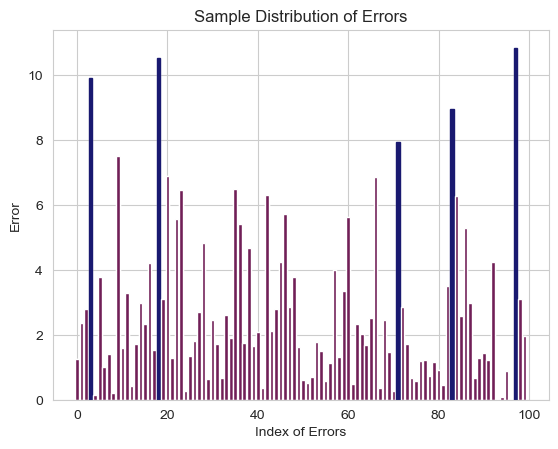

In [328]:
#visualizing the distribution of the categorical quintiles
sns.set_style('whitegrid')
sns.set_palette('rocket')
plt.bar(err_df['ind'], err_df['error'], orientation = 'vertical')
plt.xlabel('Index of Errors')
plt.ylabel('Error')
plt.title('Sample Distribution of Errors')

barlist=plt.bar(err_df['ind'], err_df['error'])
for i in outliers:
    barlist[i].set_color('midnightblue')

# plt.savefig('../figures/sample_dist_errors.png')
plt.show()

In [264]:
err;

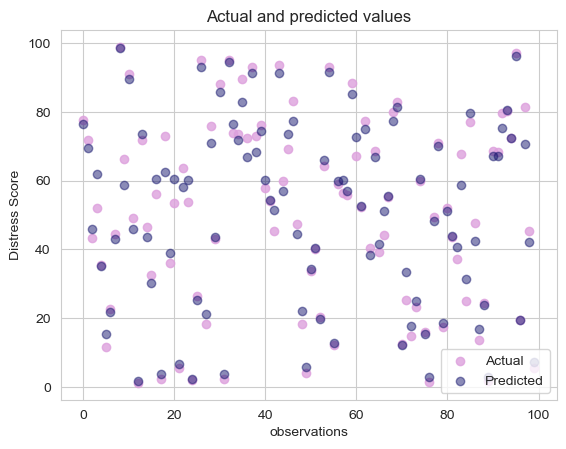

In [283]:
sns.set_style('whitegrid')
sns.set_palette('rocket')

#100 sample points
plt.scatter(x= range(0, y_true.size), y=y_true, c = 'plum', label = 'Actual', alpha = 0.8)
plt.scatter(x = range(0, y_pred.size), y=y_pred, c = 'midnightblue', label = 'Predicted', alpha = 0.5)

# X=range(0, y_pred.size)
# plt.errorbar(X, y_pred, yerr = err, fmt='o', ecolor = 'midnightblue', color='midnightblue', alpha=0.5)
plt.title('Actual and predicted values')
plt.xlabel('observations')
plt.ylabel('Distress Score')
plt.legend(loc='lower right')

# plt.savefig('../figures/true_pred.png')
plt.show()

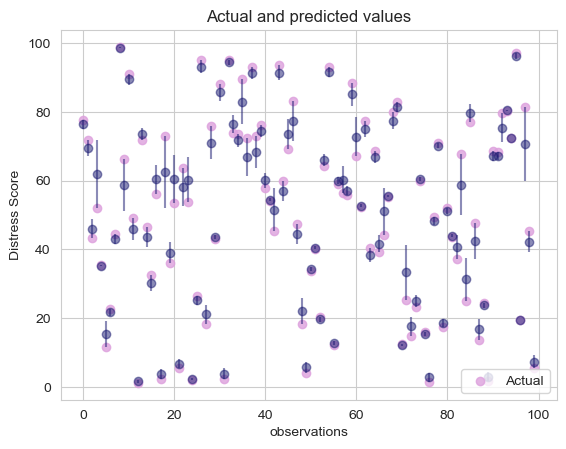

In [284]:
sns.set_style('whitegrid')
sns.set_palette('rocket')

#100 sample points
plt.scatter(x= range(0, y_true.size), y=y_true, c = 'plum', label = 'Actual', alpha = 0.8)
# plt.scatter(x = range(0, y_pred.size), y=y_pred, c = 'midnightblue', label = 'Predicted', alpha = 0.5)

X=range(0, y_pred.size)
plt.errorbar(X, y_pred, yerr = err, fmt='o', ecolor = 'midnightblue', color='midnightblue', alpha=0.5)
plt.title('Actual and predicted values')
plt.xlabel('observations')
plt.ylabel('Distress Score')
plt.legend(loc='lower right')

# plt.savefig('../figures/true_pred_errors.png')
plt.show()

#### On larger sample: 1000

In [332]:
#pulling samples from y_true and y_pred
y_test_1000 = y_test[:1000]
y_test_pred_1000 = y_test_pred_df[:1000]

In [333]:
#making sure that the y_pred values remain with their respective y_true values
y_true_1000 = y_test_1000.reset_index(drop=True)
y_pred_1000 = y_test_pred_1000.reset_index(drop=True)
y_pred_1000 = y_pred_1000.squeeze()

In [335]:
#calculating the difference between y_true and y_pred and saving the value and index to a df
err_1000 = []
ind_list_1000 = []

for i in range(len(y_true_1000)):
    err_1000.append(abs(y_true_1000[i] - y_pred_1000[i]))
    ind_list_1000.append(i)
    
err_1000 = list(err_1000)
err_df_1000 = pd.DataFrame()
err_df_1000['error'] = err_1000
err_df_1000['ind'] = ind_list_1000

In [336]:
#finding which errors are statistically significant to see if there is any pattern in where our model struggles
#using inter quartile range
Q1_1000 = np.percentile(err_df_1000['error'], 25,
                   interpolation = 'midpoint')
 
Q3_1000 = np.percentile(err_df_1000['error'], 75,
                   interpolation = 'midpoint')
IQR_1000 = Q3_1000 - Q1_1000

In [337]:
# above upper bound - plays
upper_1000 = np.where(err_df_1000['error'] >= (Q3_1000+1.5*IQR_1000))
 
# below lower bound - plays
lower_1000 = np.where(err_df_1000['error'] <= (Q1_1000-1.5*IQR_1000))

In [339]:
outliers_1000 = upper_1000[0]

In [346]:
percent_outliers_1000 = len(outliers_1000)/len(y_true_1000)
percent_outliers_1000

0.035

#### Percent Outliers in All Data

In [361]:
#pulling samples from y_true and y_pred
y_test_10000 = y_test
y_test_pred_10000 = y_test_pred_df

#making sure that the y_pred values remain with their respective y_true values
y_true_10000 = y_test_10000.reset_index(drop=True)
y_pred_10000 = y_test_pred_10000.reset_index(drop=True)
y_pred_10000 = y_pred_10000.squeeze()

In [362]:
#calculating the difference between y_true and y_pred and saving the value and index to a df
err_10000 = []
ind_list_10000 = []

for i in range(len(y_true_10000)):
    err_10000.append(abs(y_true_10000[i] - y_pred_10000[i]))
    ind_list_10000.append(i)
    
err_10000 = list(err_10000)
err_df_10000 = pd.DataFrame()
err_df_10000['error'] = err_10000
err_df_10000['ind'] = ind_list_10000

In [363]:
#finding which errors are statistically significant to see if there is any pattern in where our model struggles
#using inter quartile range
Q1_10000 = np.percentile(err_df_10000['error'], 25,
                   interpolation = 'midpoint')
 
Q3_10000 = np.percentile(err_df_10000['error'], 75,
                   interpolation = 'midpoint')
IQR_10000 = Q3_10000 - Q1_10000

# above upper bound - plays
upper_10000 = np.where(err_df_10000['error'] >= (Q3_10000+1.5*IQR_10000))
 
# below lower bound - plays
lower_10000 = np.where(err_df_10000['error'] <= (Q1_10000-1.5*IQR_10000))

In [364]:
outliers_10000 = upper_10000[0] 
percent_outliers_10000 = len(outliers_10000)/len(y_true_10000)
percent_outliers_10000

0.0306558013193636